In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import cm
from tqdm import tqdm
import json
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
from scipy.spatial import KDTree
import networkx as nx


from src.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [8]:
threshol_set = {
    'X18'  : {'threshold' : [50, 800], 'remove_no' : [15]},
    'X19'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X21'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X22'  : {'threshold' : [50, 800], 'remove_no' : []},
    'X25'  : {'threshold' : [30, 800], 'remove_no' : [9, 14, 17]},
    'X28'  : {'threshold' : [100, 800], 'remove_no' : []},
    'X30'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X33'  : {'threshold' : [60, 800], 'remove_no' : []},
    'X35'  : {'threshold' : [30, 800], 'remove_no' : [2,3,4,5,6,7,21,18]},
    'X36'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X38'  : {'threshold' : [50, 800], 'remove_no' : [34]},
    'X39'  : {'threshold' : [50, 800], 'remove_no' : []},
    'X46'  : {'threshold' : [125, 800], 'remove_no' : [1]},
    'X51'  : {'threshold' : [80, 800], 'remove_no' : []},
    'X62'  : {'threshold' : [300, 800], 'remove_no' : []},
    'X63'  : {'threshold' : [80, 800], 'remove_no' : []},
}

In [35]:
adata = sc.read_h5ad("data/adata_nichepca_all_with_domain.h5ad")
adata = ad.AnnData(
    X=adata.X, 
    obs=adata.obs,
    uns={'spatial': adata.uns['spatial']},
    obsm={'spatial': adata.obsm['spatial']}
)
adata

AnnData object with n_obs × n_vars = 3222037 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'all_slide_leiden_0.1', 'all_slide_leiden_0.3', 'all_slide_leiden_0.5', 'per_slide_leiden_0.1_1', 'per_slide_leiden_0.1_2', 'per_slide_leiden_0.2_1', 'per_slide_leiden_0.2_2', 'per_slide_leiden_0.3_1', 'per_slide_leiden_0.3_2', 'per_slide_is_glom_tmp', 'domains'
    uns: 'spatial'
    obsm: 'spatial'

In [121]:
sample_set = adata.obs['Patient_Sample_ID'].unique()
list(sample_set)

['X40_SLE',
 'X39_SLE',
 'X38_GBM',
 'X37_ANCA',
 'X36_ANCA',
 'X35_ANCA',
 'X34_ANCA',
 'X33_ANCA',
 'X63_ANCA',
 'X61_SLE',
 'X62_SLE',
 'X60_ANCA',
 'X59_ANCA',
 'X58_ANCA',
 'X57_Cntrl',
 'X32_SLE',
 'X31_SLE',
 'X30_SLE',
 'X29_GBM',
 'X28_ANCA',
 'X27_ANCA',
 'X26_ANCA',
 'X25_ANCA',
 'X56_SLE',
 'X55_SLE',
 'X54_SLE',
 'X53_ANCA',
 'X52_ANCA',
 'X50_ANCA',
 'X51_ANCA',
 'X49_ANCA',
 'X8_SLE',
 'X7_SLE',
 'X6_ANCA',
 'X4_ANCA',
 'X5_GBM',
 'X2_Cntrl',
 'X3_ANCA',
 'X1_Cntrl',
 'X48_SLE',
 'X47_SLE',
 'X46_GBM',
 'X45_ANCA',
 'X44_ANCA',
 'X43_ANCA',
 'X42_ANCA',
 'X41_Cntrl',
 'X16_SLE',
 'X15_SLE',
 'X14_ANCA',
 'X12_ANCA',
 'X13_GBM',
 'X11_ANCA',
 'X10_Cntrl',
 'X9_Cntrl',
 'X24_SLE',
 'X23_SLE',
 'X22_SLE',
 'X21_GBM',
 'X20_ANCA',
 'X19_ANCA',
 'X18_ANCA',
 'X17_ANCA']

In [453]:
## Get glom locations
i = 0
sample = sample_set[i]
sample = 'X13_GBM'

adata_i = adata[adata.obs['Patient_Sample_ID'] == sample]
df_glom_i = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', ['x', 'y']]

df_glom_i.head()

,x,y
cell_CR799fa1430-126096,5711.139646,6872.468932
cell_CR799fa1430-129434,5792.561260,6955.835564
cell_CR799fa1430-129763,5804.477040,6955.021214
cell_CR799fa1430-129875,5799.851569,6961.661382
cell_CR799fa1430-132860,5571.382479,7350.211422


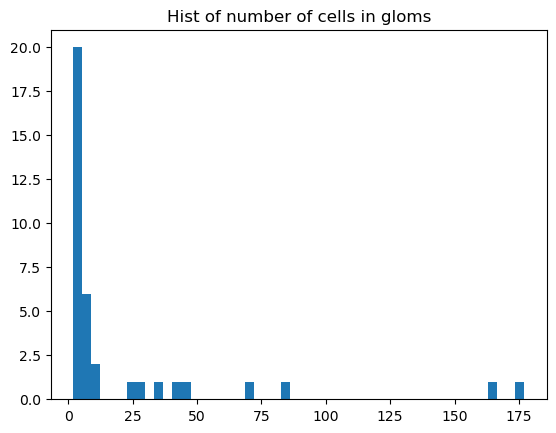

Text(0.5, 1.0, 'Isolated samples')

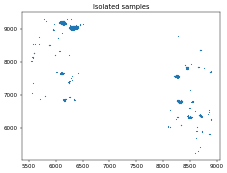

In [454]:
# Cluster gloms
## Make a distnace matrix via KDTree
coords = np.array(df_glom_i)
kdtree = KDTree(coords)
dist_mat = kdtree.sparse_distance_matrix(kdtree, max_distance=70)

## Convert into a "networkx" object
edge_index = np.array(dist_mat.nonzero())
G = nx.Graph()
G.add_edges_from(edge_index.T)

## Get connected components
cc = list(nx.connected_components(G))

## Plot hist for number of cells in gloms
sizes = np.array([len(c) for c in cc])
plt.hist(sizes, 50);
plt.title("Hist of number of cells in gloms")
plt.show()

# plot
dpi = 40
plt.figure(dpi=dpi)
plt.scatter(coords[:, 0], coords[:, 1], s=1, cmap="jet")
plt.title("Isolated samples")

In [455]:
# Set threshold
threshold = [20, 800]
remove_no = []

# threshold = [0, 8000]
# remove_no = []

cc_filtered = [c for i, c in enumerate(cc) if (len(c) > threshold[0]) and (len(c) < threshold[1]) and (i not in remove_no)]

if len(cc_filtered) == 0:
    print('No glom remained')
else:
    print(f'Number of glomes remained = {len(cc_filtered)}')
    ## set glom numbers
    filtered_nodes = np.hstack([list(c) for c in cc_filtered])
    glom_number = []
    for i in filtered_nodes:
        for n, c in enumerate(cc_filtered):
            i_in_c = list(c).count(i) > 0
            if i_in_c:
                glom_number.append(n)
                break

Number of glomes remained = 9


In [456]:
# Make glom_adata "adata_glom" for sample i
X_glom = adata_i.X[adata_i.obs['domains'] == 'Glom.', :].copy()
adata_glom = sc.AnnData(X_glom)
adata_glom.var = adata_i.var
adata_glom.obs = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', 
                              ['x', 'y', 'n_transcripts', 'domains']]
adata_glom.obs['sample'] = sample.split("_")[0]
adata_glom.obs['label'] = sample.split("_")[1]
adata_glom = adata_glom[filtered_nodes,:]
adata_glom.obs['domain_tuned'] = 'Glom.'
adata_glom.obs['glom_no'] = glom_number

In [457]:
# Add to the adata
## restrict adata to adata_i
adata_i = adata[adata.obs['Patient_Sample_ID'] == sample].copy()
df_i = adata_glom.obs.copy()

## Merge df_gnn_i to adata_i.obs
merged_df = adata_i.obs.merge(df_i[['domain_tuned', 'glom_no']], 
                              left_index=True, 
                              right_index=True,
                              how='left', 
                              suffixes=('', '_nichepca'))
adata_i.obs.shape, merged_df.shape

((65077, 35), (65077, 37))

In [458]:
adata_i.obs = merged_df
adata_i.obs.head()

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,per_slide_leiden_0.1_1,per_slide_leiden_0.1_2,per_slide_leiden_0.2_1,per_slide_leiden_0.2_2,per_slide_leiden_0.3_1,per_slide_leiden_0.3_2,per_slide_is_glom_tmp,domains,domain_tuned,glom_no
cell_CR799fa1430-105413,6692.348159,4825.683055,32.471183,1,29,1.6260,2.272,17.84,0.9959,0.9910,...,0,0,0,7,1,9,0,Other,NaN,NaN
cell_CR799fa1430-113316,6484.250659,5472.563894,32.633419,1,17,0.5587,2.362,30.43,0.9703,0.7741,...,0,0,0,7,1,9,0,Other,NaN,NaN
cell_CR799fa1430-115016,5922.435573,6131.064418,29.912907,1,11,0.5969,1.427,18.43,0.9871,0.9364,...,0,0,0,7,1,9,0,Other,NaN,NaN
cell_CR799fa1430-115269,5560.698937,6498.597122,30.563806,1,68,0.6654,8.859,102.20,0.9958,0.9747,...,0,0,0,7,1,9,0,Other,NaN,NaN
cell_CR799fa1430-115396,5543.145521,6525.301486,29.455130,1,14,0.6048,3.624,23.15,0.9821,0.8986,...,0,0,0,7,1,9,0,Other,NaN,NaN


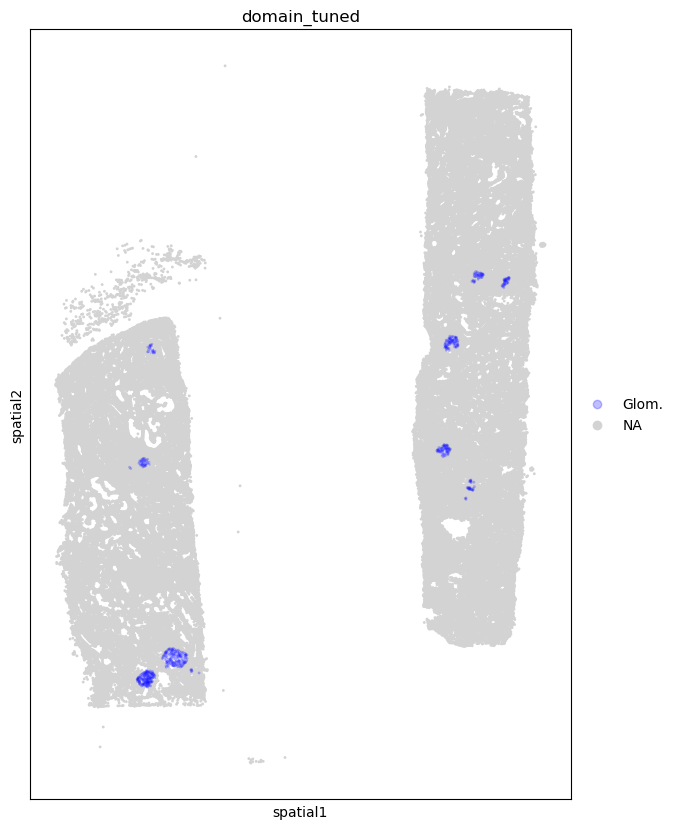

In [460]:
# Plot
plot_HE = False
show = True
slide = adata_i.obs['Slide_ID'][0]

## add color
colormap = {'Glom.': '#0000FF40'}
adata_i.obs['domain_tuned'] = pd.Categorical(adata_i.obs['domain_tuned'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['domain_tuned_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(10, 10))
sc.pl.spatial(adata_i,
              library_id=slide,
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='domain_tuned',
              size=0.5,
              ax=ax,
              show=show
             )

if show:
    plt.show()
else:
    plt.savefig(f"figure_gloms/sample_{sample.split('_')[0]}.pdf", bbox_inches='tight')
plt.close(fig)

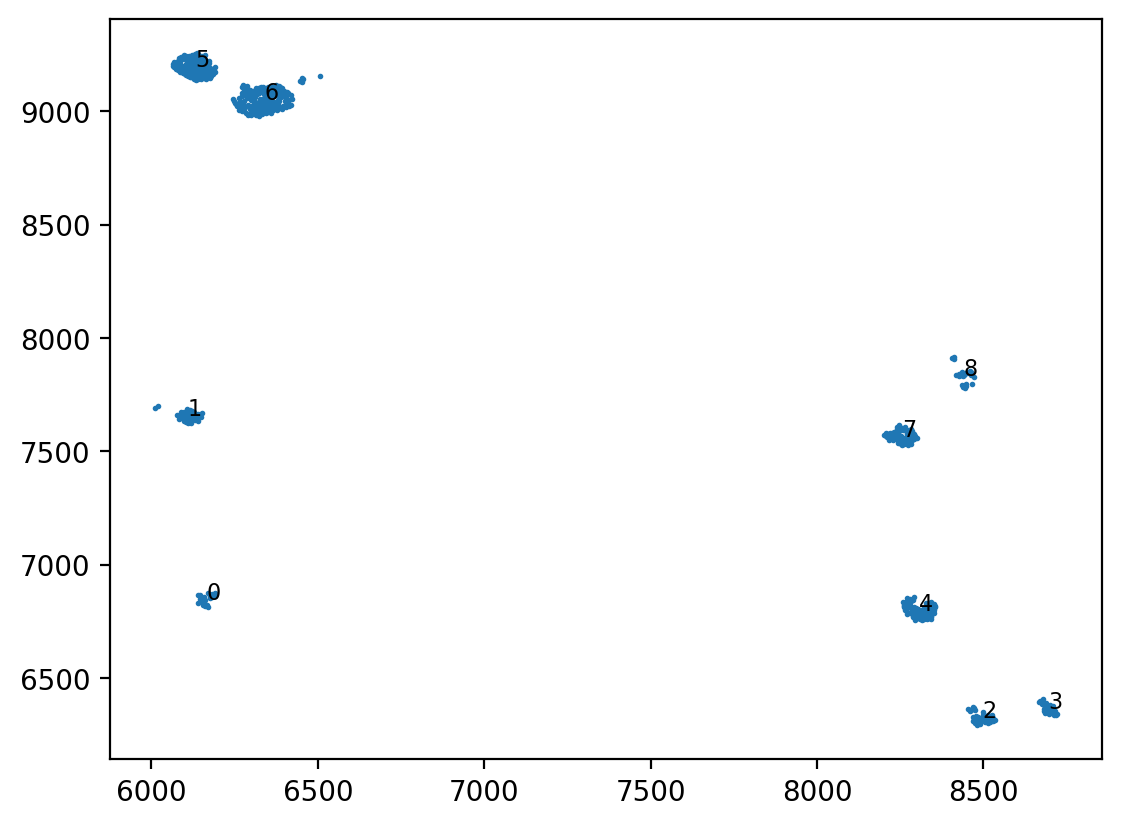

In [461]:
dpi = 200
plt.figure(dpi=dpi)
glom_mask = adata_i.obs['domain_tuned'] == 'Glom.'
plt.scatter(adata_i.obs.loc[glom_mask, 'x'], adata_i.obs.loc[glom_mask, 'y'], s=1)

for i in range(len(cc_filtered)):
    centroid = adata_i.obs.loc[adata_i.obs['glom_no'] == i, ['x', 'y']].mean()
    plt.text(centroid[0], centroid[1], f"{i}", fontsize=8)

In [462]:
print(ax.get_xlim())
print(ax.get_ylim())
sample

(5297.4168021130945, 9160.651680625)
(10058.889322241377, 4566.006566264367)


'X13_GBM'

In [463]:
adata_i.obs.to_csv(f"obs/data_tuned_glom_{sample.split('_')[0]}.csv")
f"obs/data_tuned_glom_{sample.split('_')[0]}.h5ad"

'obs/data_tuned_glom_X13.h5ad'

In [42]:
# GNN-based annotation benefits
# time
# human eror
# HE image registration missmatch
# accurate boundries

## All in a loop

In [2]:
# Read data: registered with harmony embedding
adata = sc.read_h5ad("data/adata_nichepca_all_with_domain.h5ad")
adata = ad.AnnData(
    X=adata.X, 
    obs=adata.obs,
    uns={'spatial': adata.uns['spatial']},
    obsm={'spatial': adata.obsm['spatial']}
)
sample_set = adata.obs['Patient_Sample_ID'].unique()
sample_set

['X40_SLE', 'X39_SLE', 'X38_GBM', 'X37_ANCA', 'X36_ANCA', ..., 'X21_GBM', 'X20_ANCA', 'X19_ANCA', 'X18_ANCA', 'X17_ANCA']
Length: 63
Categories (63, object): ['X1_Cntrl', 'X2_Cntrl', 'X3_ANCA', 'X4_ANCA', ..., 'X60_ANCA', 'X61_SLE', 'X62_SLE', 'X63_ANCA']

In [5]:
threshold = [30, 800]

for sample in sample_set:
    print(sample)

    adata_i = adata[adata.obs['Patient_Sample_ID'] == sample]
    df_glom_i = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', ['x', 'y']]

    # Cluster gloms
    ## Make a distnace matrix via KDTree
    coords = np.array(df_glom_i)
    kdtree = KDTree(coords)
    dist_mat = kdtree.sparse_distance_matrix(kdtree, max_distance=50)

    ## Convert into a "networkx" object
    edge_index = np.array(dist_mat.nonzero())
    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    ## Get connected components
    cc = list(nx.connected_components(G))

    # Filter gloms
    remove_no = []
    cc_filtered = [c for i, c in enumerate(cc) if (len(c) > threshold[0]) and (len(c) < threshold[1]) and (i not in remove_no)]

    if len(cc_filtered) == 0:
        print('No glom remained')
        continue
    ## set glom numbers
    filtered_nodes = np.hstack([list(c) for c in cc_filtered])
    glom_number = []
    for i in filtered_nodes:
        for n, c in enumerate(cc_filtered):
            i_in_c = list(c).count(i) > 0
            if i_in_c:
                glom_number.append(n)
                break

    # Make glom_adata "adata_glom" for sample i
    X_glom = adata_i.X[adata_i.obs['domains'] == 'Glom.', :].copy()
    adata_glom = sc.AnnData(X_glom)
    adata_glom.var = adata_i.var
    adata_glom.obs = adata_i.obs.loc[adata_i.obs['domains'] == 'Glom.', 
                                  ['x', 'y', 'n_transcripts', 'domains']]
    adata_glom.obs['sample'] = sample.split("_")[0]
    adata_glom.obs['label'] = sample.split("_")[1]
    adata_glom = adata_glom[filtered_nodes,:]
    adata_glom.obs['domain_tuned'] = 'Glom.'
    adata_glom.obs['glom_no'] = glom_number

    # Add to the adata
    ## restrict adata to adata_i
    adata_i = adata[adata.obs['Patient_Sample_ID'] == sample].copy()
    df_i = adata_glom.obs.copy()

    ## Merge df_gnn_i to adata_i.obs
    merged_df = adata_i.obs.merge(df_i[['domain_tuned', 'glom_no']], 
                                  left_index=True, 
                                  right_index=True,
                                  how='left', 
                                  suffixes=('', '_nichepca'))

    adata_i.obs = merged_df

    # Save adata
    adata_i.obs.to_csv(f"obs/data_tuned_glom_{sample.split('_')[0]}.csv")

    # Plot
    plot_HE = False
    show = False
    slide = adata_i.obs['Slide_ID'][0]
    
    ## add color
    colormap = {'Glom.': '#0000FF40'}
    adata_i.obs['domain_tuned'] = pd.Categorical(adata_i.obs['domain_tuned'], 
                                           categories=list(colormap.keys()), 
                                           ordered=True)
    adata_i.uns['domain_tuned_colors'] = list(colormap.values())
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sc.pl.spatial(adata_i,
                  library_id=slide,
                  img_key='he_downscaled_aligned' if plot_HE else None,
                  color='domain_tuned',
                  size=0.5,
                  ax=ax,
                  show=show
                 )
    
    if show:
        plt.show()
    else:
        plt.savefig(f"figure_gloms/sample_{sample.split('_')[0]}.pdf", bbox_inches='tight')
    plt.close(fig)

X40_SLE
X39_SLE
X38_GBM
X37_ANCA
X36_ANCA
X35_ANCA
X34_ANCA
X33_ANCA
X63_ANCA
X61_SLE
X62_SLE
X60_ANCA
X59_ANCA
No glom remained
X58_ANCA
X57_Cntrl
X32_SLE
X31_SLE
X30_SLE
X29_GBM
X28_ANCA
X27_ANCA
X26_ANCA
X25_ANCA
X56_SLE
X55_SLE
X54_SLE
X53_ANCA
X52_ANCA
X50_ANCA
X51_ANCA
X49_ANCA
X8_SLE
X7_SLE
X6_ANCA
X4_ANCA
No glom remained
X5_GBM
X2_Cntrl
X3_ANCA
X1_Cntrl
X48_SLE
X47_SLE
X46_GBM
X45_ANCA
X44_ANCA
X43_ANCA
X42_ANCA
No glom remained
X41_Cntrl
X16_SLE
X15_SLE
X14_ANCA
X12_ANCA
X13_GBM
X11_ANCA
No glom remained
X10_Cntrl
X9_Cntrl
X24_SLE
X23_SLE
X22_SLE
X21_GBM
X20_ANCA
X19_ANCA
X18_ANCA
X17_ANCA


In [11]:
# Merge all adata_i into adata

## Read data: registered with harmony embedding
adata = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/merged_processed_cleaned.h5ad")

sample_set = adata.obs['Patient_Sample_ID'].unique()
sample_set

['X40_SLE', 'X39_SLE', 'X38_GBM', 'X37_ANCA', 'X36_ANCA', ..., 'X21_GBM', 'X20_ANCA', 'X19_ANCA', 'X18_ANCA', 'X17_ANCA']
Length: 63
Categories (63, object): ['X1_Cntrl', 'X2_Cntrl', 'X3_ANCA', 'X4_ANCA', ..., 'X60_ANCA', 'X61_SLE', 'X62_SLE', 'X63_ANCA']

In [12]:
# Add empty cols to adata
adata.obs['sample'] = 'na'
adata.obs['label'] = 'na'
adata.obs['nichepca_domain'] = 'na'
adata.obs['nichepca_domain_tuned'] = float('nan')
adata.obs['nichepca_glom_no'] = float('nan')

In [13]:
for sample in tqdm(sample_set):

    adata.obs.loc[adata.obs['Patient_Sample_ID'] == sample, 'sample'] = sample.split("_")[0]
    adata.obs.loc[adata.obs['Patient_Sample_ID'] == sample, 'label'] = sample.split("_")[1]

    obs_path = f"obs/data_tuned_glom_{sample.split('_')[0]}.h5ad"
    if os.path.exists(obs_path):
        # read NichePCA annotation result
        adata_i_obs = pd.read_csv(f"obs/data_tuned_glom_{sample.split('_')[0]}.h5ad", index_col=0)
    
        adata.obs.loc[adata_i_obs.index, 'nichepca_domain'] = adata_i_obs['domains']
        adata.obs.loc[adata_i_obs.index, 'nichepca_domain_tuned'] = adata_i_obs['domain_tuned']
        adata.obs.loc[adata_i_obs.index, 'nichepca_glom_no'] = adata_i_obs['glom_no']
    else:
        print("pass")
        pass

 19%|█▉        | 12/63 [00:03<00:13,  3.89it/s]

pass


 57%|█████▋    | 36/63 [00:09<00:04,  5.82it/s]

pass


 71%|███████▏  | 45/63 [00:12<00:05,  3.13it/s]

pass


 83%|████████▎ | 52/63 [00:13<00:03,  3.13it/s]

pass


100%|██████████| 63/63 [00:18<00:00,  3.36it/s]


In [14]:
# adata.obs

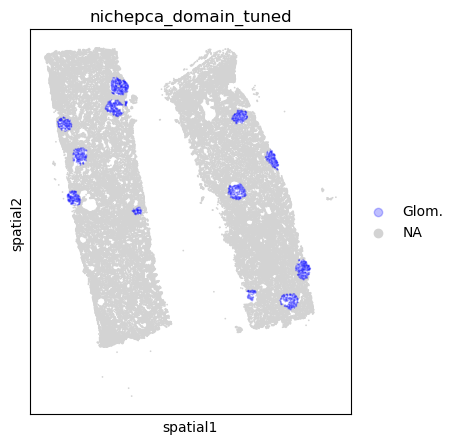

In [15]:
# # Final check plot
plot_HE = False

sample = 30
adata_i = adata[adata.obs['sample'] == f'X{sample}'].copy()
slide = adata_i.obs['Slide_ID'][0]


## add color
colormap = {'Glom.': '#0000FF40'}#, 'Other': '#1100040'}
adata_i.obs['nichepca_domain_tuned'] = pd.Categorical(adata_i.obs['nichepca_domain_tuned'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
adata_i.uns['nichepca_domain_tuned_colors'] = list(colormap.values())

fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.spatial(adata_i,
              library_id=slide,
              img_key='he_downscaled_aligned' if plot_HE else None,
              color='nichepca_domain_tuned',
              size=0.5,
              ax=ax)
plt.show()

In [16]:
# adata.write("adata/adata_nichepca_all_with_domain_tuned_v0.h5ad")

In [17]:
adata.obs['nichepca_domain_tuned'] = adata.obs['nichepca_domain_tuned'].astype('category')
adata.obs['nichepca_domain_tuned'] = adata.obs['nichepca_domain_tuned'].cat.add_categories('Other')
adata.obs['nichepca_domain_tuned'] = adata.obs['nichepca_domain_tuned'].fillna('Other')

adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].astype('category')
adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].cat.add_categories('Other')
adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].fillna('Other')
adata.obs['nichepca_glom_no'] = [int(i) if i!= 'Other' else 'Other' for i in adata.obs['nichepca_glom_no']]
adata.obs['nichepca_glom_no'] = adata.obs['nichepca_glom_no'].astype(str).astype('category')
adata.obs['nichepca_domain_tuned'], adata.obs['nichepca_glom_no']

(cell_CRfb095a77d-1         Other
 cell_CRfb095a77d-2         Other
 cell_CRfb095a77d-3         Other
 cell_CRfb095a77d-5         Other
 cell_CRfb095a77d-6         Other
                            ...  
 cell_CRc71d71060-597925    Other
 cell_CRc71d71060-598041    Other
 cell_CRc71d71060-598270    Other
 cell_CRc71d71060-598508    Other
 cell_CRc71d71060-598872    Other
 Name: nichepca_domain_tuned, Length: 3222037, dtype: category
 Categories (2, object): ['Glom.', 'Other'],
 cell_CRfb095a77d-1         Other
 cell_CRfb095a77d-2         Other
 cell_CRfb095a77d-3         Other
 cell_CRfb095a77d-5         Other
 cell_CRfb095a77d-6         Other
                            ...  
 cell_CRc71d71060-597925    Other
 cell_CRc71d71060-598041    Other
 cell_CRc71d71060-598270    Other
 cell_CRc71d71060-598508    Other
 cell_CRc71d71060-598872    Other
 Name: nichepca_glom_no, Length: 3222037, dtype: category
 Categories (70, object): ['0', '1', '10', '11', ..., '7', '8', '9', 'Other'])

In [18]:
adata.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,n_genes,celltype_l1,celltype_l1_codes,celltype_l1_prob,Biopsy_ID,sample,label,nichepca_domain,nichepca_domain_tuned,nichepca_glom_no
cell_CRfb095a77d-1,2285.790178,1164.057381,32.829188,1,79,2.0240,2.141,39.03,0.9975,0.9916,...,55,MAC,8,0.999994,0011695 - X1,X40,SLE,Prox. Tubule,Other,Other
cell_CRfb095a77d-2,2298.342622,1219.741069,31.465535,4,32,1.0850,4.614,29.50,0.9771,0.9288,...,17,PT,16,1.000000,0011695 - X1,X40,SLE,Prox. Tubule,Other,Other
cell_CRfb095a77d-3,2271.434052,1245.859500,32.062796,2,67,3.0590,2.990,21.90,0.9971,0.9884,...,44,FIB,6,1.000000,0011695 - X1,X40,SLE,DistaL Con. Tubule,Other,Other
cell_CRfb095a77d-5,2257.346907,1259.955827,31.273945,2,56,2.1420,9.229,26.14,0.9964,0.9707,...,40,FIB,6,0.999103,0011695 - X1,X40,SLE,DistaL Con. Tubule,Other,Other
cell_CRfb095a77d-6,2277.712022,1237.595244,35.395148,2,9,1.6980,3.283,5.30,0.9826,0.9400,...,7,DTL,4,0.582253,0011695 - X1,X40,SLE,DistaL Con. Tubule,Other,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CRc71d71060-597925,2747.360264,4957.516627,24.097605,2,73,1.5480,3.617,47.15,0.9971,0.6334,...,10,MAC,8,1.000000,0011216 - X2,X24,SLE,Other,Other,Other
cell_CRc71d71060-598041,4592.548620,1655.438877,24.254944,2,35,0.9893,1.844,35.38,0.9951,0.6206,...,6,MAC,8,1.000000,0011216 - X3,X24,SLE,Other,Other,Other
cell_CRc71d71060-598270,8540.113826,9224.561804,19.515240,3,46,1.3870,2.667,33.16,0.9969,0.7152,...,8,FIB,6,1.000000,0011216 - X9,X21,GBM,Other,Other,Other
cell_CRc71d71060-598508,4264.902000,2582.697217,25.121288,3,24,1.1420,5.004,21.02,0.9914,0.7517,...,6,VSM/P,20,0.998473,0011216 - X3,X24,SLE,Other,Other,Other


In [ ]:
adata.write("data/adata_nichepca_with_domain_tuned_v1.h5ad")